In [2]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys
import time

from collections import defaultdict

from blackjack import BlackjackEnv
import plotting

matplotlib.style.use('ggplot')

In [3]:
env = BlackjackEnv()

In [80]:
Q = defaultdict(lambda: np.zeros(env.action_space.n))

In [117]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        probs = np.zeros(nA)+epsilon/(nA)
        probs[np.argmax(Q[observation])] += 1-epsilon
        return probs
    return policy_fn

In [125]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    returns = defaultdict(dict)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for episode in range(num_episodes + 1): 
        observation = env.reset()
        action = env.action_space.sample()
        
        rewards = []
        state_action = []
        done = False
        
        while not done: 
            state_action.append((observation, action))
            observation, reward, done, _ = env.step(action)
            rewards.append(reward)
            action = env.action_space.sample()            
        
        G = 0
        for ep, s_a in reversed(list(enumerate(state_action))): 
            G = discount_factor * G + rewards[ep]
            if s_a not in returns: 
                returns[s_a]['G'] = G
                returns[s_a]['count'] = 1
            else: 
                returns[s_a]['G'] += G
                returns[s_a]['count'] += 1
                
            state = s_a[0]
            action = s_a[1]
            Q[state][action] = returns[s_a]['G'] / returns[s_a]['count']
        
        policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    return Q, policy

In [128]:
start = time.clock()

Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

end = time.clock()
print("\n",end - start,"s")


 43.80545599999999 s


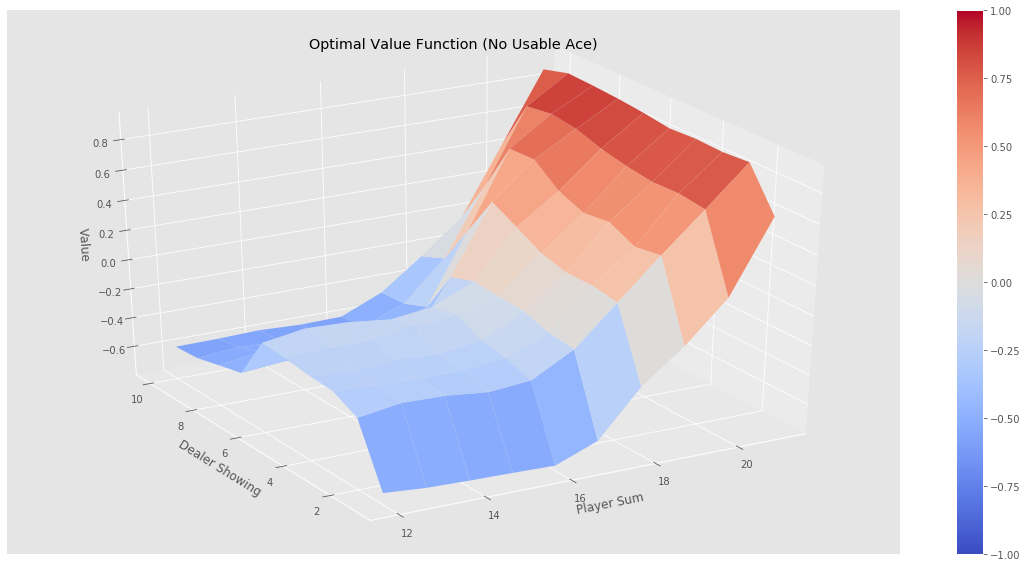

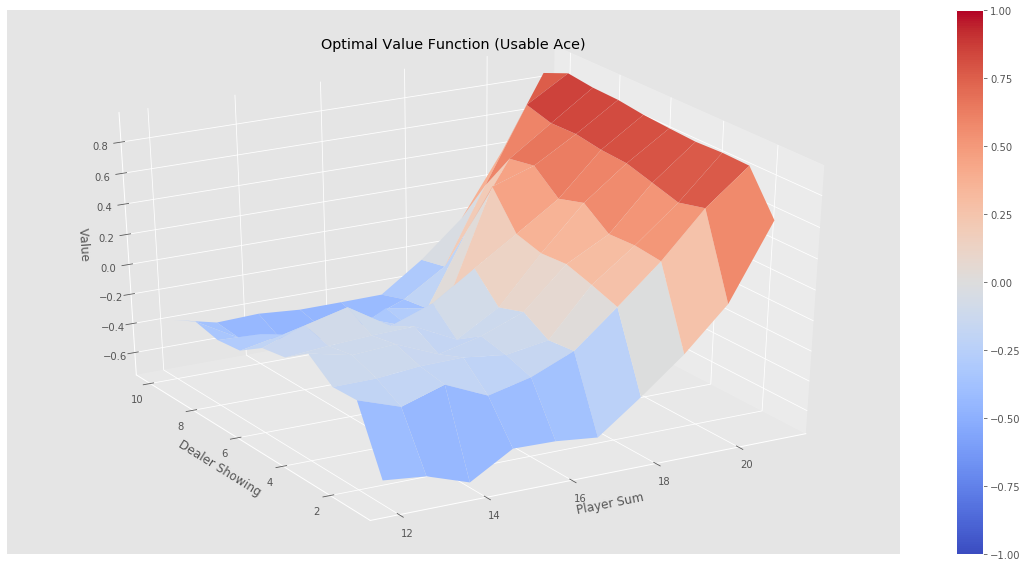

In [132]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")